In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutups
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib
import matplotlib.pyplot as plt
import mediapy
from rich.pretty import pprint
from tqdm.auto import tqdm

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

# Multiple Doors

,,,

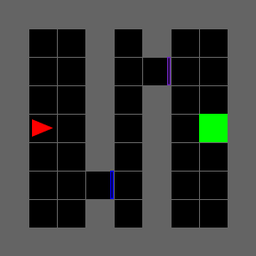
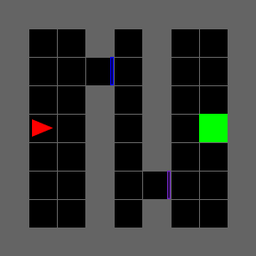
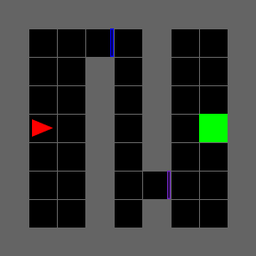
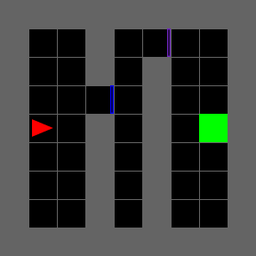

In [2]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
for i in [0, 1, 2, 3]:
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=100, task_num=0)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    # env = ActionRepeatWrapper(env, action_repeat=3) # test
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

  0%|          | 0/4 [00:00<?, ?it/s]

{
│   'actions': (98000,),
│   'layout_type': (98000, 4),
│   'next_observations': (98000, 2),
│   'observations': (98000, 2),
│   'terminals': (98000,)
}

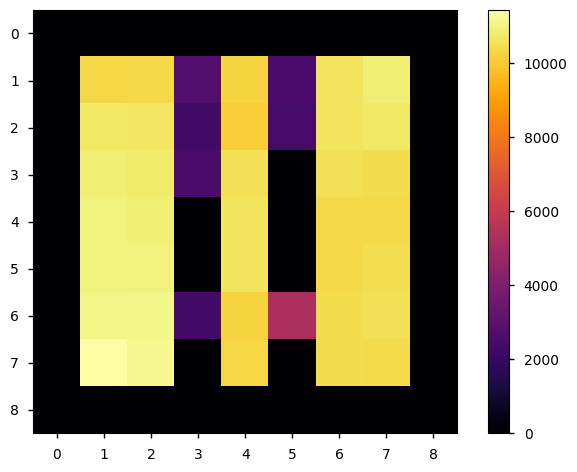

In [3]:
from envs.minigrid.env_utils import random_exploration, q_learning

train_layout_data = []

# NUM_TRAIN_LAYOUTS = 3
# NUM_TRAIN_STEPS = 100
# NUM_TRAIN_EPISODES = 1000

# for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
#     env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=None) # comment agent_start_pos for same start pos
#     env._gen_grid = partial(env._gen_grid, layout_type=i)
#     env = MinigridWrapper(env)
#     # dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
#     dataset, env = q_learning(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, epsilon=0.75, num_mdp=NUM_TRAIN_LAYOUTS)
#     train_layout_data.append(dataset)

NUM_TRAIN_LAYOUTS = 4
NUM_TRAIN_STEPS = 99
NUM_TRAIN_EPISODES = 1000

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=None) # comment agent_start_pos for same start pos
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
    train_layout_data.append(dataset)

pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=(env.env.unwrapped.width, env.env.unwrapped.height))
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

# Train Dynamics-Aware FB

In [4]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_dynamics_discrete.yaml',
                                                            f'agent.number_of_meta_envs={NUM_TRAIN_LAYOUTS}',
                                                            f'agent.z_dim=100'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
# SAVING
np.save(f"../aux_data/doors_meta{NUM_TRAIN_LAYOUTS}_data", arr=jax.device_get(whole_data))
whole_data = np.load(f"/home/m_bobrin/ZeroShotRL/aux_data/doors_meta{NUM_TRAIN_LAYOUTS}_data.npy", allow_pickle=True).item()

print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'dynamics_fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 400000,
│   'log_interval': 10000,
│   'eval_interval': 50000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'dynamics_fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 512,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 100,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [1024, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'use_context': True,
│   │   'number_of_meta_envs': 4,
│   │   'dyn_encoder_warmup_steps': 50000,
│   │   'n_blocks': 4,
│   │   'n_heads': 4,
│   │   'emb_dim': 96,
│   │   'mlp_dim': 128,
│   │   'output_dim': 8,
│   │   'context_len': 100,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False,
│   │   'world_pred_hidden': [128, 128, 128]
│   },
│   'env': {'env_name': 'fourrooms-dynamics', 'discrete': True},
│   'tags': ['dynamics-fb', '4rooms', 'discrete']
}

{'actions': (392000,), 'layout_type': (392000, 4), 'next_observations': (392000, 2), 'observations': (392000, 2), 'terminals': (392000,)}


In [5]:
sys.path.append("..")
from agents.dynamics_fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
batch = gc_whole_dataset.sample(2, layout_type=None, get_traj_batch=True, context_length=NUM_TRAIN_STEPS)[1]
# with jax.disable_jit():
fb_agent, info = fb_agent.update(batch, train_context_embedding=False)

{'actions': (98,), 'layout_type': (98, 9), 'next_observations': (98, 2), 'observations': (98, 2), 'terminals': (98,)}


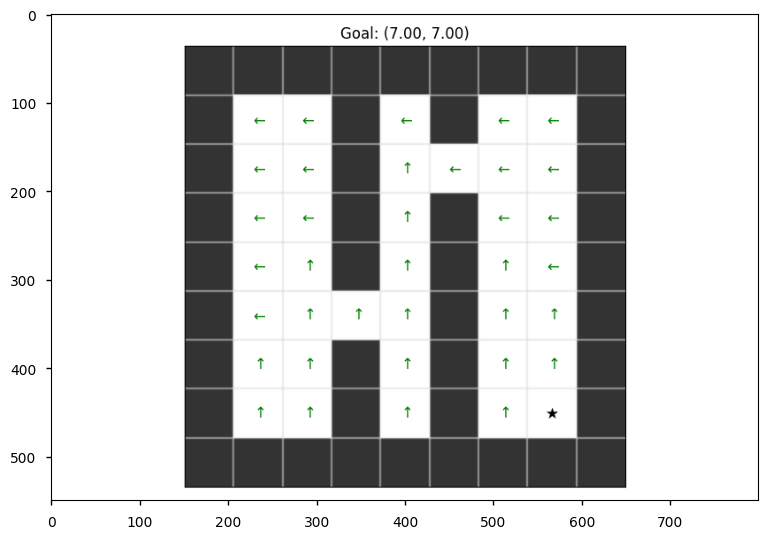

In [6]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$'
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            action_name = action_names[action]
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

def visualize_policy_image(layout_type, task_num):
    mdp_type = np.zeros((NUM_TRAIN_LAYOUTS, ))
    if mdp_type is not None:
        if layout_type == 0:
            mdp_type[0] = 1
        elif layout_type == 1:
            mdp_type[1] = 1
        else:
            mdp_type[2] = 1

    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    
    if fb_config['agent']['use_context']:
        dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=layout_type, num_mdp=NUM_TRAIN_LAYOUTS + 5)
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None,:,None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding=dynamics_embedding.squeeze()
        mdp_type=None
        
    latent_z = fb_agent.infer_z(goal, mdp_num=mdp_type, dynamics_embedding=dynamics_embedding)
    example_batch = gc_whole_dataset.sample(1)
    pred_policy_img = policy_image_grid(env, example_batch,
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions,
                                                                                rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z,
                                                                    mdp_num=None, dynamics_embedding=dynamics_embedding[None], temperature=0.0),
                                                    goal=goal)
    return pred_policy_img

pred_policy_img = visualize_policy_image(layout_type=7, task_num=2)
plt.imshow(pred_policy_img)
plt.tight_layout()

{'actions': (98,), 'layout_type': (98, 9), 'next_observations': (98, 2), 'observations': (98, 2), 'terminals': (98,)}


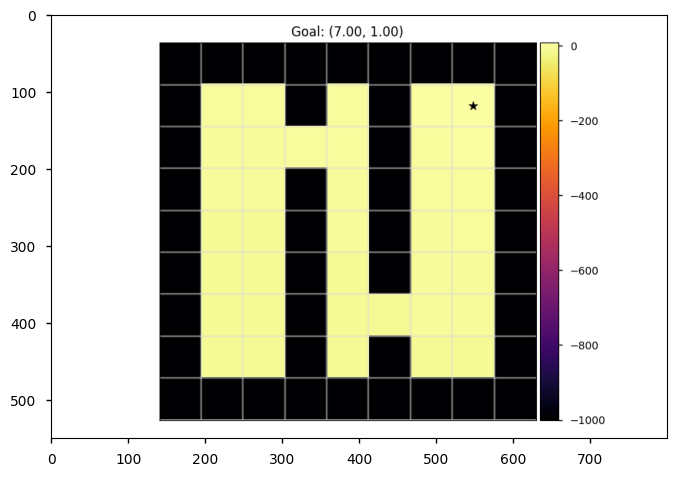

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)

    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1)).max(-1)[0])
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax

def visualize_value_image(layout_type, task_num):
    mdp_type = None
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    
    if fb_config['agent']['use_context']:
        dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=layout_type, num_mdp=NUM_TRAIN_LAYOUTS + 5) # 5 for unseen
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None, :, None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding = dynamics_embedding.squeeze()
        mdp_type=None
    latent_z = jax.device_get(fb_agent.infer_z(goal, mdp_num=mdp_type, dynamics_embedding=dynamics_embedding)[None])
    pred_value_img = value_image_fourrooms(env, example_batch,
                                value_fn=partial(fb_agent.predict_q, z=latent_z, mdp_num=None,
                                                dynamics_embedding=dynamics_embedding[None]),
                                action_fn=None, goal=goal)
    return pred_value_img

pred_value_img = visualize_value_image(1, task_num=1)
plt.imshow(pred_value_img)


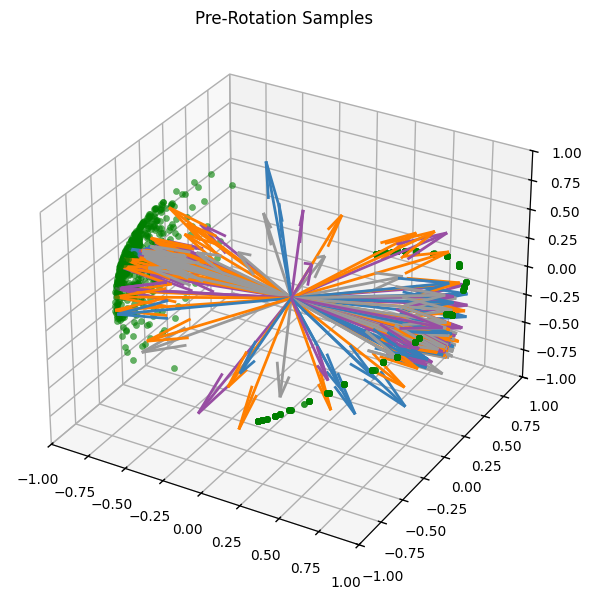

In [8]:
if fb_config['agent']['use_context']:
    plot_layouts = []
    for i in range(NUM_TRAIN_LAYOUTS):
        cur_layout = gc_whole_dataset.sample(512, layout_type=i, context_length=NUM_TRAIN_STEPS)[1]
        plot_layouts.append(cur_layout)
        
    plot_layouts = functools.reduce(concatenate_dicts, plot_layouts)

    cmap = matplotlib.colormaps['Set1']
    c = cmap(np.linspace(0, 1, 7)) # number of doors
    layouts_for_embeddings = []
    colors = []
    for i in range(1, 7):
        cur_layout_indx = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == i), 1))[0]
        cur_layout_traj = jax.tree_util.tree_map(lambda arr: arr[cur_layout_indx], plot_layouts)
        if len(cur_layout_indx) > 1:
            layouts_for_embeddings.append(cur_layout_traj)
            colors.append([c[i]] * cur_layout_traj['traj_actions'].shape[0])
    plot_layouts = functools.reduce(concatenate_dicts, layouts_for_embeddings)
    colors = np.concatenate(colors)
    
    first_dyn_indices = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 1), 1))[0]
    first_dyn = jax.tree_util.tree_map(lambda arr: arr[first_dyn_indices], plot_layouts)

    sec_dyn_indices = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 2), 1))[0]
    sec_dyn = jax.tree_util.tree_map(lambda arr: arr[sec_dyn_indices], plot_layouts)
    
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

dynamics_embedding_mean, std = fb_agent.network.select('dynamic_transformer')(plot_layouts['traj_states'], plot_layouts['traj_actions'],
                                                                        plot_layouts['traj_next_states'], train=False)
dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)

# Visualization for 3D case
def visualize_3d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(z_pre[:,0], z_pre[:,1], z_pre[:,2], alpha=0.6)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='r', lw=2, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(z_post[:,0], z_post[:,1], z_post[:,2], alpha=0.6, c='orange')
    # ax2.quiver(0, 0, 0, *anchor, color='g', lw=2, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

def visualize_dynamics(z_pres, z_posts, anchor, colors):
    fig = plt.figure(figsize=(12, 6))
    anchor = (anchor / jnp.linalg.norm(anchor, axis=-1, keepdims=True))
    ax1 = fig.add_subplot(111, projection='3d')
    for i in range(z_pres.shape[0]):
        ax1.scatter(z_pres[i,:, 0], z_pres[i,:, 1], z_pres[i, :, 2], alpha=0.6, c='green')#c[i])
    for i in range(1, colors.shape[0]):
        ax1.quiver(0, 0, 0, *anchor[i], color=colors[i], lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

final_indices = np.cumsum(jnp.array([layouts_for_embeddings[i]['traj_states'].shape[0] for i in range(len(layouts_for_embeddings))]))
samples_from_trajs = []
prev_inxs = 0
for i in range(len(final_indices)):
    key=jax.random.fold_in(GLOBAL_KEY, i)
    cur_sel = jax.random.choice(key=key, a=np.arange(prev_inxs, final_indices[i]), shape=(40, ))
    samples_from_trajs.append(cur_sel)
    prev_inxs = final_indices[i] + 1
    
samples_from_trajs_indxs = np.stack(samples_from_trajs).reshape(-1)
tsne = PCA(3, random_state=42).fit_transform(dynamics_embedding[samples_from_trajs_indxs])
# z_pre, z_post, anchor = sample_z_nd(1000, 3, GLOBAL_KEY, jnp.atleast_2d(tsne), 100)
batch = gc_whole_dataset.sample(1024, layout_type=None, get_traj_batch=True, context_length=NUM_TRAIN_STEPS)[1]
z = fb_agent.sample_mixed_z(batch, fb_config['agent']['z_dim'], GLOBAL_KEY)
z = PCA(3, random_state=42).fit_transform(z)
z = (z / jnp.linalg.norm(z, axis=-1)[:, None])[:, None]
visualize_dynamics(z, z, tsne, colors=colors[samples_from_trajs_indxs])

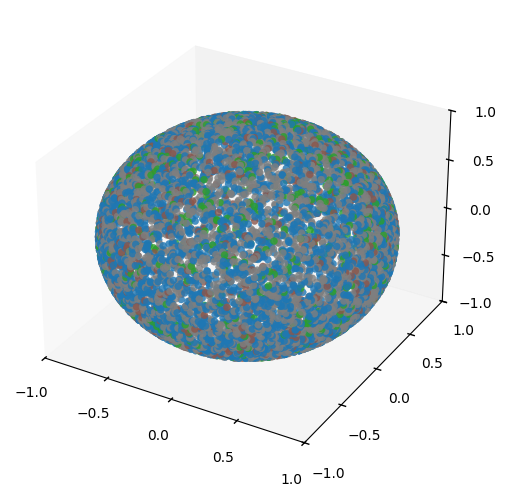

In [57]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Visualization for 3D case
def visualize_3d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(z_pre[:,0], z_pre[:,1], z_pre[:,2], alpha=0.6)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='r', lw=2, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(z_post[:,0], z_post[:,1], z_post[:,2], alpha=0.6, c='orange')
    # ax2.quiver(0, 0, 0, *anchor, color='g', lw=2, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()
    
def get_colors_by_composite_labels(labels: np.ndarray):
    """
    Assign colors based on composite labels (arrays of size 3).
    Each unique combination of 3 values gets the same color.
    
    Args:
        labels: numpy array of shape (batch, 3) where each row is a composite label
        
    Returns:
        List of color strings in hex format
    """
    cmap = matplotlib.colormaps['Set1']
    color_palette = cmap(np.linspace(0, 1, 3)) # number of doors
    
    # Convert each composite label to a tuple (hashable) for dictionary keys
    label_tuples = [tuple(label) for label in labels]
    unique_labels = list(set(label_tuples))  # Get unique composite labels
    
    # Create mapping from composite label to color
    label_to_color = {label: color_palette[i % len(color_palette)] 
                    for i, label in enumerate(unique_labels)}
    
    # Generate color array
    colors = [label_to_color[tuple(label)] for label in labels]
    
    return colors

def visualize_dynamics(z_pres, z_posts, anchor, z_colors, colors):
    fig = plt.figure(figsize=(12, 6))
    anchor = (anchor / jnp.linalg.norm(anchor, axis=-1, keepdims=True))
    ax1 = fig.add_subplot(111, projection='3d')
    for i in range(z_pres.shape[0]):
        ax1.scatter(z_pres[i,:, 0], z_pres[i,:, 1], z_pres[i, :, 2], alpha=0.6, c=z_colors[i])#c[i])
    for i in range(1, colors.shape[0]):
        ax1.quiver(0, 0, 0, *anchor[i], color=colors[i], lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

def project_z(z):
    return z / jnp.linalg.norm(z, axis=-1, keepdims=True)

def sample_z(batch_size, latent_dim, key):
    z = jax.random.normal(shape=(batch_size, latent_dim), key=key)
    return z

final_indices = np.cumsum(jnp.array([layouts_for_embeddings[i]['traj_states'].shape[0] for i in range(len(layouts_for_embeddings))]))
samples_from_trajs = []
prev_inxs = 0
for i in range(len(final_indices)):
    cur_sel = np.random.choice(np.arange(prev_inxs, final_indices[i]), size=35)
    samples_from_trajs.append(cur_sel)
    prev_inxs = final_indices[i] + 1
    
samples_from_trajs_indxs = np.stack(samples_from_trajs).reshape(-1)
    
sphere_directions = sample_z(8000, fb_config['agent']['z_dim'], GLOBAL_KEY)
projected_sphere_dirs = project_z(PCA(3, random_state=42).fit_transform(sphere_directions))

F1, F2 = fb_agent.network.select('f_value')(jnp.repeat(jnp.array([4, 1])[None], repeats=sphere_directions.shape[0], axis=0), 
                                        sphere_directions, jnp.repeat(dynamics_embedding[3][None], repeats=sphere_directions.shape[0], axis=0))
Q1 = jnp.einsum('sda, sd -> sa', F1, sphere_directions)
Q2 = jnp.einsum('sda, sd -> sa', F2, sphere_directions)
Q = jnp.minimum(Q1, Q2)
best_actions = jnp.argmax(Q, axis=-1)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('tab10')
colors = cmap(best_actions / 4)
ax.scatter(
    projected_sphere_dirs[:, 0],
    projected_sphere_dirs[:, 1],
    projected_sphere_dirs[:, 2],
    c=colors,
    s=25,
    alpha=0.8
)
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xticks(np.arange(-1, 1.5, 0.5))
ax.set_zticks(np.arange(-1, 1.5, 0.5))
# ax.set_title('Decision Boundary of F on the Unit Sphere')
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
plt.show()

In [40]:
np.unique(best_actions, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([3419,  670,  632, 3279]))

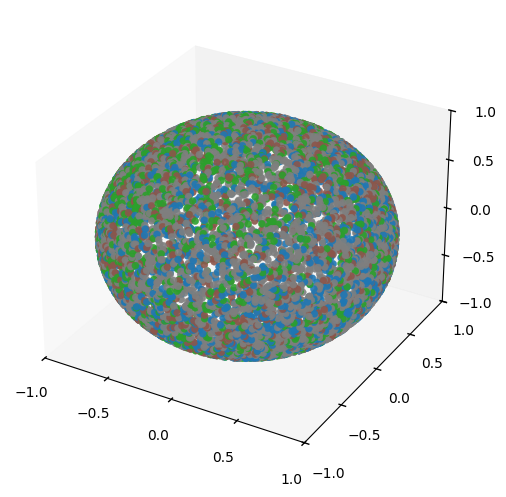

In [61]:
sphere_directions = sample_z(8000, fb_config['agent']['z_dim'], GLOBAL_KEY)
projected_sphere_dirs = project_z(PCA(3, random_state=42).fit_transform(sphere_directions))

#jnp.zeros((sphere_directions.shape[0], 8))
F1, F2 = fb_agent.network.select('f_value')(jnp.repeat(jnp.array([4, 1])[None], repeats=sphere_directions.shape[0], axis=0), 
                                        sphere_directions, jnp.repeat(dynamics_embedding[-1][None], repeats=sphere_directions.shape[0], axis=0))#, jnp.repeat(dynamics_embedding[0][None], repeats=sphere_directions.shape[0], axis=0))
Q1 = jnp.einsum('sda, sd -> sa', F1, sphere_directions)
Q2 = jnp.einsum('sda, sd -> sa', F2, sphere_directions)
Q = jnp.minimum(Q1, Q2)
best_actions = jnp.argmax(Q, axis=-1)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('tab10')
colors = cmap(best_actions / 4)
ax.scatter(
    projected_sphere_dirs[:, 0],
    projected_sphere_dirs[:, 1],
    projected_sphere_dirs[:, 2],
    c=colors,
    s=25,
    alpha=0.9,
    # edgecolors='black'
)
# ax.set_title('Decision Boundary of F on the Unit Sphere')
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xticks(np.arange(-1, 1.5, 0.5))
ax.set_zticks(np.arange(-1, 1.5, 0.5))
plt.savefig("sphere.svg", dpi=300)
plt.show()

In [50]:
np.unique(best_actions, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1821, 1522, 1444, 3213]))

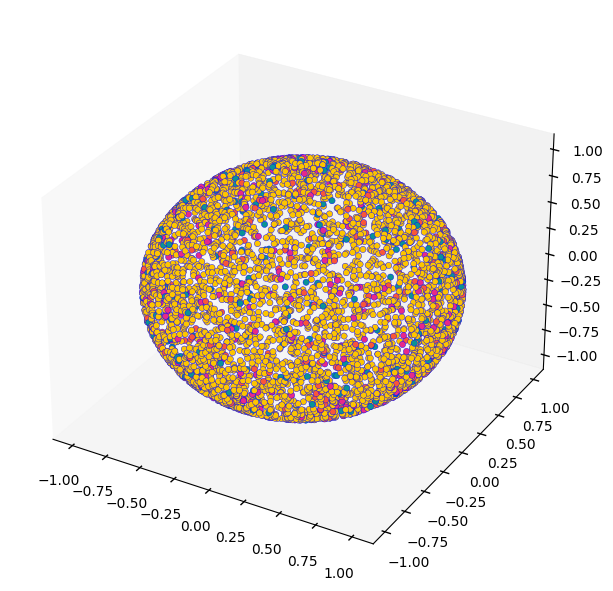

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def sample_sphere_points(n_points, dominant_fraction=0.85):
#     """
#     Sample points uniformly on the surface of a sphere.
    
#     Parameters:
#     - n_points: int, number of points to sample.
#     - dominant_fraction: float, fraction of points assigned the dominant color.
    
#     Returns:
#     - points: ndarray of shape (n_points, 3), 3D coordinates on the sphere.
#     - color_idx: ndarray of shape (n_points,), integer labels 0-3 indicating color choice.
#     """
#     # Sample Gaussian vectors and normalize to lie on the sphere
#     vec = np.random.normal(size=(n_points, 3))
#     vec /= np.linalg.norm(vec, axis=1)[:, None]
    
#     # Define probabilities: one dominant, three others roughly equal
#     probs = [dominant_fraction] + [(1 - dominant_fraction) / 3] * 3
#     color_idx = np.random.choice(4, size=n_points, p=probs)
    
#     return vec, color_idx

# # Example usage
# n_points = 5000
# points, color_idx = sample_sphere_points(n_points)

# # Define a visually appealing four-color palette
# palette = np.array([
#     "#fdc500",  # Teal (dominant)
#     "#0a9396",  # Orange0a9396
#     "#f95738",  # Purple
#     "#e7298a"   # Pink
# ])

# colors = palette[color_idx]

# # Plot the sphere without axes
# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(points[:, 0], points[:, 1], points[:, 2],
#         c=colors, s=20, linewidths=0.3, alpha=1, edgecolors='b')

# ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# plt.tight_layout()
# plt.savefig("sphere_l2.svg", dpi=150)
# plt.show()


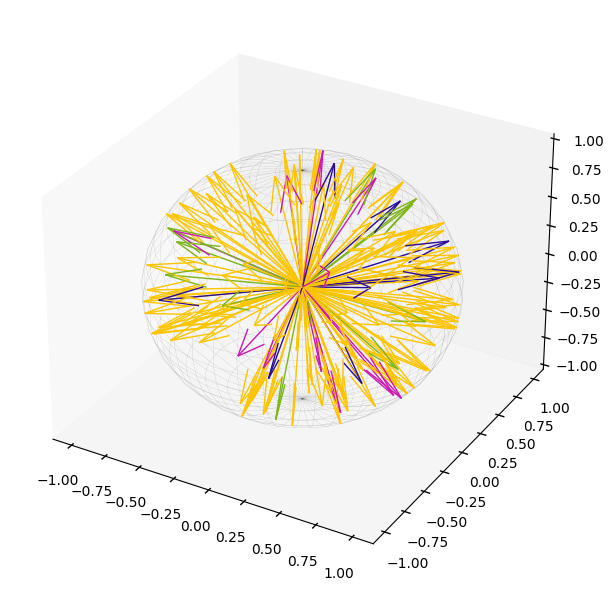

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def sample_sphere_points(n_points, dominant_fraction=0.8):
    vec = np.random.normal(size=(n_points, 3))
    vec /= np.linalg.norm(vec, axis=1)[:, None]
    probs = [dominant_fraction] + [(1 - dominant_fraction) / 3] * 3
    color_idx = np.random.choice(4, size=n_points, p=probs)
    return vec, color_idx

# Smaller sample size for stability
n_points = 150
points, color_idx = sample_sphere_points(n_points)

# Nice palette fdc500fc
palette = ["#fdc500fc", "#cb17b3fc", "#2a0a96fc", "#7cb518"]
# cb17b3fc fdc500fc
colors = np.array(palette)[color_idx]

# Plot arrows
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(
    np.zeros(n_points), np.zeros(n_points), np.zeros(n_points),
    points[:, 0], points[:, 1], points[:, 2],
    color=colors, length=1.0, normalize=True, linewidth=1, alpha=1.0
)

# Dotted sphere outline
u, v = np.meshgrid(np.linspace(0, 2*np.pi, 40), np.linspace(0, np.pi, 20))
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, linestyle='-', linewidth=0.1, alpha=0.4, color='black')
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
plt.tight_layout()
plt.savefig("sphere_l2.svg", dpi=100)
plt.show()


""

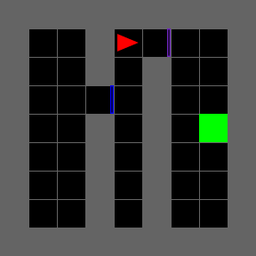

In [13]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=100, task_num=0, agent_start_pos=(4, 1))
env._gen_grid = partial(env._gen_grid, layout_type=3)
env = MinigridWrapper(env)
# env = ActionRepeatWrapper(env, action_repeat=3) # test
env.reset()

layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

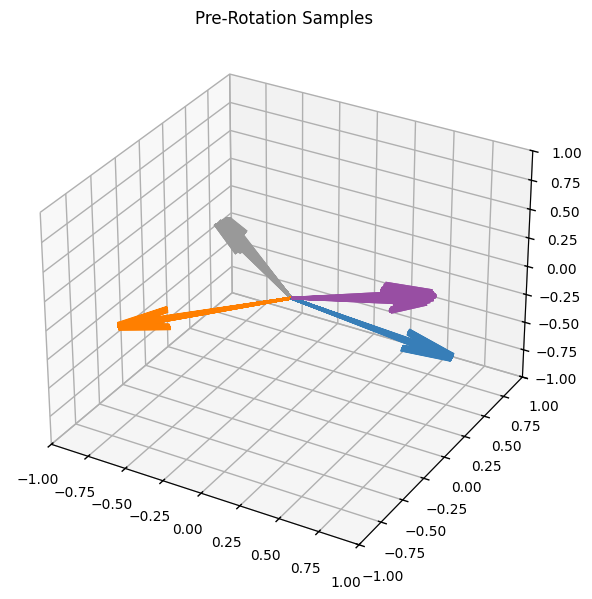

In [23]:
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_dynamics(anchor, colors):
    fig = plt.figure(figsize=(12, 6))
    anchor = (anchor / jnp.linalg.norm(anchor, axis=-1, keepdims=True))
    ax1 = fig.add_subplot(111, projection='3d')
    for i in range(1, colors.shape[0]):
        ax1.quiver(0, 0, 0, *anchor[i], color=colors[i], lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()


obs, info = env.reset()
goal = info.get("goal_pos")

# with jax.disable_jit():
if fb_config['agent']['use_context']:
    plot_layouts = []
    for i in range(NUM_TRAIN_LAYOUTS):
        cur_layout = gc_whole_dataset.sample(1024, layout_type=i, context_length=NUM_TRAIN_STEPS)[1]
        plot_layouts.append(cur_layout)
        
    plot_layouts = functools.reduce(concatenate_dicts, plot_layouts)

    cmap = matplotlib.colormaps['Set1']
    c = cmap(np.linspace(0, 1, 7)) # number of doors
    layouts_for_embeddings = []
    colors = []
    for i in range(1, 7):
        cur_layout_indx = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == i), 1))[0]
        cur_layout_traj = jax.tree_util.tree_map(lambda arr: arr[cur_layout_indx], plot_layouts)
        if len(cur_layout_indx) > 1:
            layouts_for_embeddings.append(cur_layout_traj)
            colors.append([c[i]] * cur_layout_traj['traj_actions'].shape[0])
    plot_layouts = functools.reduce(concatenate_dicts, layouts_for_embeddings)
    colors = np.concatenate(colors)
    
pbar = tqdm(range(150_000))
for update_step in pbar:
    batch = gc_whole_dataset.sample(fb_config['agent']['batch_size'], layout_type=None, get_traj_batch=True, context_length=NUM_TRAIN_STEPS)[1]
    fb_agent, info = fb_agent.update(batch, train_context_embedding=True if update_step < 50_000 else False)
    
    if update_step % 4_000 == 0:
        clear_output()
        dynamics_embedding_mean, std = fb_agent.network.select('dynamic_transformer')(plot_layouts['traj_states'], plot_layouts['traj_actions'],
                                                                        plot_layouts['traj_next_states'], train=False)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
        tsne = PCA(3, random_state=42).fit_transform(dynamics_embedding)
        # sphere_directions = sample_z(1024, fb_config['agent']['z_dim'], GLOBAL_KEY)
        # projected_sphere_dirs = project_z(PCA(3, random_state=42).fit_transform(sphere_directions))

        # F1, F2 = fb_agent.network.select('f_value')(jnp.repeat(jnp.array([4, 1])[None], repeats=sphere_directions.shape[0], axis=0), 
        #                                         sphere_directions, jnp.repeat(dynamics_embedding[3][None], repeats=sphere_directions.shape[0], axis=0))
        # Q1 = jnp.einsum('sda, sd -> sa', F1, sphere_directions)
        # Q2 = jnp.einsum('sda, sd -> sa', F2, sphere_directions)
        # Q = jnp.minimum(Q1, Q2)
        # best_actions = jnp.argmax(Q, axis=-1)
        
        visualize_dynamics(tsne, colors=colors)
    
    if update_step % 5_000 == 0:
        clear_output()
        fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
        dynamics_embedding_mean, std = fb_agent.network.select('dynamic_transformer')(plot_layouts['traj_states'], plot_layouts['traj_actions'],
                                                                        plot_layouts['traj_next_states'], train=False)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
        tsne = PCA(3, random_state=42).fit_transform(dynamics_embedding)
        # tsne = PCA().fit_transform(dynamics_embedding)
        x, y = tsne[:, 0], tsne[:, 1]
        ax[0, 0].scatter(x, y, color=colors, edgecolors='black')
        
        pred_policy_img = visualize_policy_image(layout_type=0, task_num=update_step % 3)
        ax[1,0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(layout_type=0, task_num=update_step % 3)
        ax[1, 1].imshow(pred_value_img)
        
        pred_policy_img = visualize_policy_image(layout_type=1, task_num=(update_step+1) % 3)
        ax[2,0].imshow(pred_policy_img)
        
        pred_value_img = visualize_value_image(layout_type=1, task_num=(update_step+1) % 3)
        ax[2, 1].imshow(pred_value_img)
        
        pred_policy_img = visualize_policy_image(layout_type=2, task_num=(update_step+1) % 3)
        ax[3,0].imshow(pred_policy_img)

        pred_value_img = visualize_value_image(layout_type=2, task_num=(update_step+1) % 3)
        ax[3, 1].imshow(pred_value_img)
        
        fig.suptitle(f"Training step: {update_step}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Test zero-shot

In [8]:
env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=(1, 4))
env._gen_grid = partial(env._gen_grid, layout_type=18) # not seen during training
env = MinigridWrapper(env)

all_obses = []
all_actions = []
all_next_obses = []

renders = []
for i in range(1):
    renders = []
    obs, _ = env.reset()
    reward=0
    done = False
    obses = []
    actions = []
    next_obses = []
    step = 0
    while step < NUM_TRAIN_STEPS:
        step += 1
        obses.append(np.array(obs))
        action = env.action_space.sample()
        actions.append(action[None])
        obs, rew, terminated, truncated, _ = env.step(action)
        next_obses.append(np.array(obs))
        renders.append(env.render())
        
    all_obses.append(np.stack(obses))
    all_actions.append(np.stack(actions))
    all_next_obses.append(np.stack(next_obses))
    
obses = np.stack(all_obses)
actions = np.stack(all_actions)
next_obses = np.stack(all_next_obses)

mediapy.show_video(
    renders
)

In [9]:
plot_layouts = []
for i in range(NUM_TRAIN_LAYOUTS):
    cur_layout = gc_whole_dataset.sample(512, layout_type=i, context_length=NUM_TRAIN_STEPS)[1]
    plot_layouts.append(cur_layout)
    
plot_layouts = functools.reduce(concatenate_dicts, plot_layouts)

cmap = matplotlib.colormaps['Set1']
c = cmap(np.linspace(0, 1, 7)) # number of doors
layouts_for_embeddings = []
colors = []
for i in range(1, 7):
    cur_layout_indx = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == i), 1))[0]
    cur_layout_traj = jax.tree_util.tree_map(lambda arr: arr[cur_layout_indx], plot_layouts)
    if len(cur_layout_indx) > 1:
        layouts_for_embeddings.append(cur_layout_traj)
        colors.append([c[i]] * cur_layout_traj['traj_actions'].shape[0])
plot_layouts = functools.reduce(concatenate_dicts, layouts_for_embeddings)
colors = np.concatenate(colors)

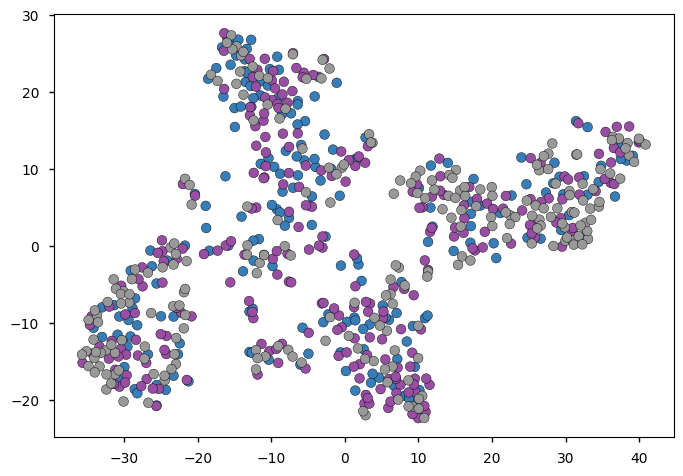

In [14]:
from sklearn.manifold import TSNE

dynamics_embedding_mean, std = fb_agent.network.select('dynamic_transformer')(plot_layouts['traj_states'], plot_layouts['traj_actions'],
                                                                            plot_layouts['traj_next_states'], train=False)
dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
zs = fb_agent.infer_z(plot_layouts['observations'], dynamics_embedding=dynamics_embedding)

tsne = TSNE(random_state=42)
projected_tsne = tsne.fit_transform(zs)
plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=colors, edgecolors='black')

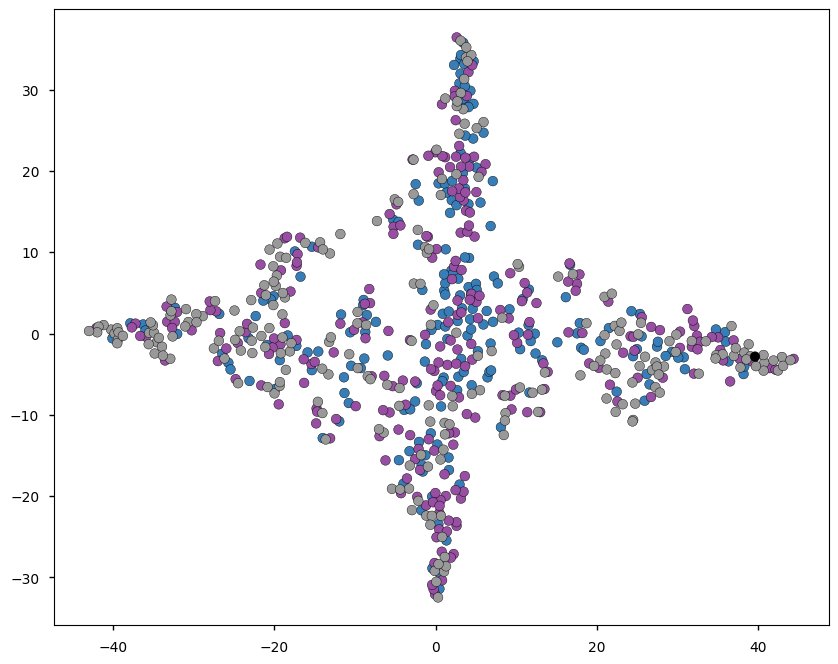

In [13]:
from sklearn.manifold import TSNE

all_boxes_obs_test = np.concatenate([plot_layouts['traj_states'], obses])
all_boxes_actions_test = np.concatenate([plot_layouts['traj_actions'], actions])
all_boxes_nobs_test = np.concatenate([plot_layouts['traj_next_states'], next_obses])

dynamics_embedding_mean, std = fb_agent.network.select('dynamic_transformer')(all_boxes_obs_test, all_boxes_actions_test,
                                                                            all_boxes_nobs_test, train=False)

dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
black_rgb = matplotlib.colors.to_rgba('black')
black_colors = [black_rgb] * obses.shape[0]

final_colors = np.concatenate([
    colors,
    black_colors
])
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(tsne[:, 0], tsne[:, 1], 
            edgecolors='black',
            c=final_colors)

{'actions': (99,), 'layout_type': (99, 15), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}


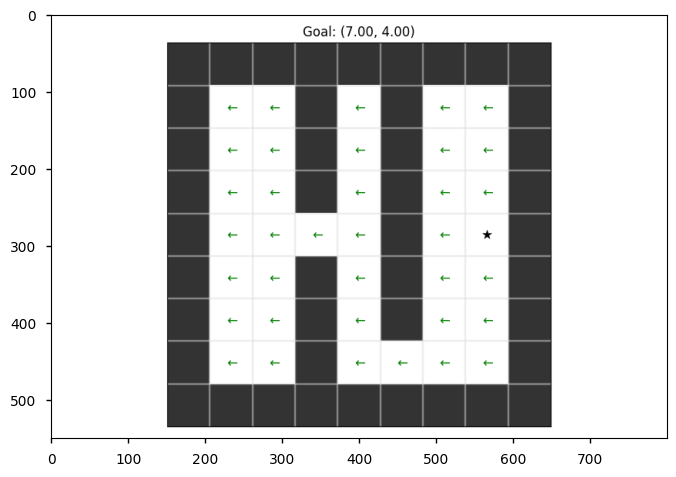

In [31]:
fig, ax = plt.subplots()
pred_policy_img = visualize_policy_image(layout_type=5, task_num=0)
ax.imshow(pred_policy_img)